Code taken from https://jrmihalj.github.io/estimating-transmission-by-fitting-mechanistic-models-in-Stan/

In [1]:
library(deSolve)
library(dplyr)
library(ggplot2)
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: StanHeaders

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



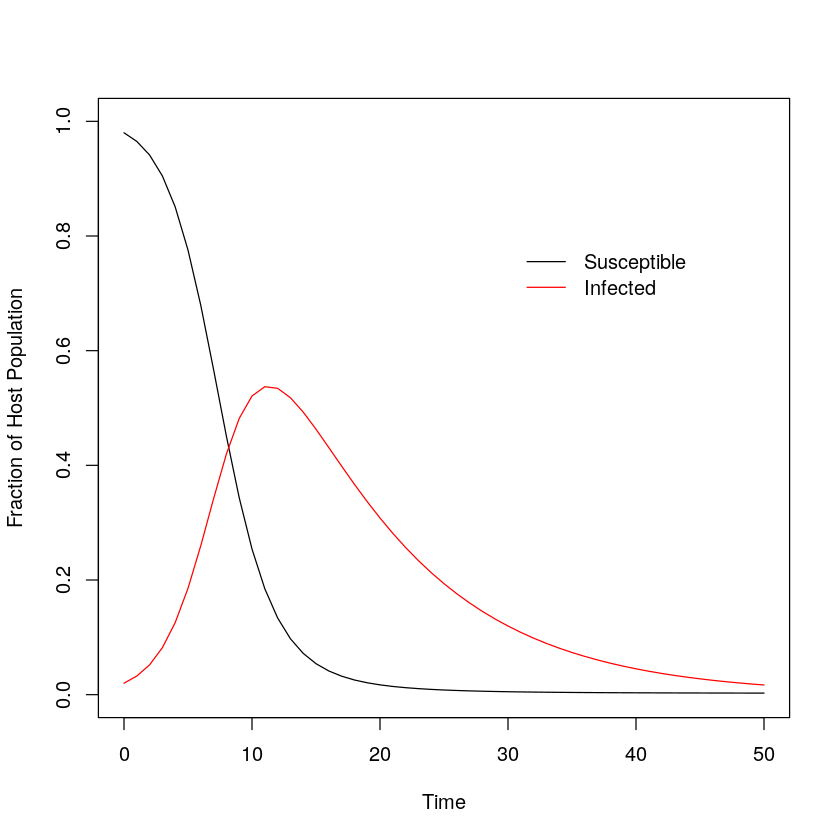

In [2]:
# To simulate the data, we need to assign initial conditions.
# In practice, these will likely be unknown, but can be estimated from the data.

I0 = 0.02    # initial fraction infected
S0 = 1 - I0 # initial fraction susceptible
R0 = 0

# Assign transmission and pathogen-induced death rates:
beta = 0.60
gamma = 0.10

# We will use the package deSolve to integrate, which requires certain data structures.
# Store parameters and initial values
# Parameters must be stored in a named list.
params <- list(beta = beta,
              gamma = gamma)

# Initial conditions are stored in a vector
inits <- c(S0, I0, R0)

# Create a time series over which to integrate.
# Here we have an epidemic that is observed over t_max number of days (or weeks or etc).
t_min = 0
t_max = 50
times = t_min:t_max

# We must create a function for the system of ODEs.
# See the 'ode' function documentation for further insights.
SIR <- function(t, y, params) {
  with(as.list(c(params, y)), {
    
    dS = - beta * y[1] * y[2]
    
    dI = beta * y[1] * y[2] - gamma * y[2]
    
    dR = gamma * y[2]
    
    res <- c(dS,dI,dR)
    list(res)
  })
}

# Run the integration:
out <- ode(inits, times, SIR, params, method="ode45")

# Store the output in a data frame:
out <- data.frame(out)
colnames(out) <- c("time", "S", "I", "R")

# quick plot of the epidemic
plot(NA,NA, xlim = c(t_min, t_max), ylim=c(0, 1), xlab = "Time", ylab="Fraction of Host Population")
lines(out$S ~ out$time, col="black")
lines(out$I ~ out$time, col="red")
legend(x = 30, y = 0.8, legend = c("Susceptible", "Infected"), 
       col = c("black", "red"), lty = c(1, 1), bty="n")

In [3]:
sample_days = 20 # number of days sampled throughout the epidemic
sample_n = 25 # number of host individuals sampled per day

# Choose which days the samples were taken. 
# Ideally this would be daily, but we all know that is difficult.
sample_time = sort(sample(1:t_max, sample_days, replace=F))

# Extract the "true" fraction of the population that is infected on each of the sampled days:
sample_propinf = out[out$time %in% sample_time, 3]

# Generate binomially distributed data.
# So, on each day we sample a given number of people (sample_n), and measure how many are infected.
# We expect binomially distributed error in this estimate, hence the random number generation.
sample_y = rbinom(sample_days, sample_n, sample_propinf)

In [4]:
# The Stan model statement:
cat(
'
functions {
  
  // This largely follows the deSolve package, but also includes the x_r and x_i variables.
  // These variables are used in the background.
  
  real[] SI(real t,
            real[] y,
            real[] params,
            real[] x_r,
            int[] x_i) {
      
      real dydt[3];
      
      dydt[1] = - params[1] * y[1] * y[2];
      dydt[2] = params[1] * y[1] * y[2] - params[2] * y[2];
      dydt[3] = params[2] * y[2];
      
      return dydt;
    }
  
}

data {
  int<lower = 1> n_obs; // Number of days sampled
  int<lower = 1> n_params; // Number of model parameters
  int<lower = 1> n_difeq; // Number of differential equations in the system
  int<lower = 1> n_sample; // Number of hosts sampled at each time point.
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data
  
  int y[n_obs]; // The binomially distributed data
  real t0; // Initial time point (zero)
  real ts[n_obs]; // Time points that were sampled
  
  real fake_ts[n_fake]; // Time points for "predicted"/"unsampled" data
}

transformed data {
  real x_r[0];
  int x_i[0];
}

parameters {
  real<lower = 0> params[n_params]; // Model parameters
  real<lower = 0, upper = 1> S0; // Initial fraction of hosts susceptible
}

transformed parameters{
  real y_hat[n_obs, n_difeq]; // Output from the ODE solver
  real y0[n_difeq]; // Initial conditions for both S and I

  y0[1] = S0;
  y0[2] = 1 - S0;
  y0[3] = 0;
  
  y_hat = integrate_ode_rk45(SI, y0, t0, ts, params, x_r, x_i);
  
}

model {
  params ~ normal(0, 2); //constrained to be positive
  S0 ~ normal(0.5, 0.5); //constrained to be 0-1.
  
  y ~ binomial(n_sample, y_hat[, 2]); //y_hat[,2] are the fractions infected from the ODE solver
  
}

generated quantities {
  // Generate predicted data over the whole time series:
  real fake_I[n_fake, n_difeq];
  
  fake_I = integrate_ode_rk45(SI, y0, t0, fake_ts, params, x_r, x_i);
  
}

', 
file = "SI_fit.stan", sep="", fill=T)

# FITTING

# For stan model we need the following variables:

stan_d = list(n_obs = sample_days,
              n_params = length(params),
              n_difeq = length(inits),
              n_sample = sample_n,
              n_fake = length(1:t_max),
              y = sample_y,
              t0 = 0,
              ts = sample_time,
              fake_ts = c(1:t_max))

# Which parameters to monitor in the model:
params_monitor = c("y_hat", "y0", "params", "fake_I")

# Test / debug the model:
test = stan("SI_fit.stan",
            data = stan_d,
            pars = params_monitor,
            chains = 1, iter = 10)

# Fit and sample from the posterior
mod = stan(fit = test,
           data = stan_d,
           pars = params_monitor,
           chains = 3,
           warmup = 500,
           iter = 1500)

# You should do some MCMC diagnostics, including:
#traceplot(mod, pars="lp__")
#traceplot(mod, pars=c("params", "y0"))
#summary(mod)$summary[,"Rhat"]

# These all check out for my model, so I'll move on.

# Extract the posterior samples to a structured list:
posts <- extract(mod)


SAMPLING FOR MODEL 'SI_fit' NOW (CHAIN 1).
Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: binomial_lpmf: Probability parameter[13] is -3.93828e-07, but must be in the interval [0, 1]  (in 'model73332a4da4d5_SI_fit' at line 64)

Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: binomial_lpmf: Probability parameter[4] is -3.15966e-08, but must be in the interval [0, 1]  (in 'model73332a4da4d5_SI_fit' at line 64)

Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: binomial_lpmf: Probability parameter[3] is -4.60316e-08, but must be in the interval [0, 1]  (in 'model73332a4da4d5_SI_fit' at line 64)

Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: binomial_lpmf: Probability parameter[10] is -9.5

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is NA, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”
Warning message:
“The largest R-hat is NA, indicating chains have not mixed.
Running the chains for more 